In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/EECE693_Project")


In [2]:
BASE_DIR = "/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA"

TRAIN_DIR = f"{BASE_DIR}/train/images"
VAL_DIR   = f"{BASE_DIR}/val/images"
TEST_DIR  = f"{BASE_DIR}/test/images"

TRAIN_LABELS = f"{BASE_DIR}/train_labels.csv"
VAL_LABELS   = f"{BASE_DIR}/val_labels.csv"
TEST_LABELS  = f"{BASE_DIR}/test_labels.csv"

In [3]:
import pandas as pd

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

In [4]:
df_train.head()


,img_name,class,label,source_set,height,width
0,901-3.png,Naskh,يومئذ تعرضون لا تخفى منكم خافية فأما من أوتي ك...,Set2,256,4000
1,Al-Haj-22-38-Thuluth_segment_no_2.png,Thuluth,ان الله يدافع عن الذين ءامنوا,Set1,256,640
2,296-2.png,Naskh,لذلك العبد و الأمة ما شاء الله و قال صلى الله,Set3,256,1696
3,Al-Mumtahanah-60-4-Diwani-1_segment_no_0.png,Diwani,ربنا عليك توكلنا وإليك أنبنا وإليك المصير,Set1,256,960
4,Al-Sharh_segment_no_4.png,Naskh,فرغت فانصب وإلى ربك فارغب,Set1,256,1888


In [6]:
# Normalize labels
for df_ in [df_train, df_val, df_test]:
    df_["label"] = df_["label"].astype(str).apply(normalize_label)

NameError: name 'normalize_label' is not defined

In [19]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))

        # >>> INSERT HERE <<<
        MAX_WIDTH = 600
        if img.shape[1] > MAX_WIDTH:
          img = cv2.resize(img, (MAX_WIDTH, H_TARGET), interpolation=cv2.INTER_AREA)

        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths):
    return torch.clamp(widths // 4, min=1, max=64)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        input_lens = torch.clamp(widths.to(DEVICE) // 4, min=1)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP ======================
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            # Fix: input lengths must match the time dimension (T) of the model output
            T = log_probs_main.size(0)  # sequence length
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    scheduler.step()

    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.3f}, "
          f"WER {val_metrics['wer']:.3f}, StyleAcc {val_metrics['style_acc']:.3f}")

# ====================== TEST ======================
test_metrics = evaluate(model, test_loader)
print("TEST:", test_metrics)



Device: cuda
Charset size: 49


/tmp/ipython-input-438537127.py:133: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-438537127.py:135: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-438537127.py:136: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-438537127.py:138: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=8, m

Epoch 01:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 1: Loss 3.2408, CER 0.931, WER 0.997, StyleAcc 0.799


Epoch 02:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 2: Loss 3.2329, CER 0.910, WER 1.000, StyleAcc 0.789


Epoch 03:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 3: Loss 3.1534, CER 0.892, WER 0.990, StyleAcc 0.809


Epoch 04:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 4: Loss 3.1783, CER 0.747, WER 1.398, StyleAcc 0.809


Epoch 05:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 5: Loss 3.2207, CER 0.714, WER 1.388, StyleAcc 0.783


Epoch 06:   0%|          | 0/126 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 6: Loss 3.2171, CER 0.720, WER 1.461, StyleAcc 0.757


Epoch 07:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 7: Loss 3.9753, CER 0.978, WER 1.900, StyleAcc 0.741


Epoch 08:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 8: Loss 3.1704, CER 0.943, WER 1.000, StyleAcc 0.743


Epoch 09:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 9: Loss 3.1823, CER 0.812, WER 0.977, StyleAcc 0.743


Epoch 10:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 10: Loss 3.1994, CER 0.976, WER 1.000, StyleAcc 0.367
TEST: {'loss': 3.11879675051801, 'cer': 0.9761866641720668, 'wer': 1.0, 'style_acc': 0.7435387673956262}


Device: cuda
Charset size: 49


/tmp/ipython-input-2585713651.py:133: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-2585713651.py:135: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-2585713651.py:136: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2585713651.py:138: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=

Epoch 01:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 1: Loss 3.2177, CER 0.9308, WER 0.9923, StyleAcc 0.8108


Epoch 02:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 2: Loss 3.3168, CER 0.9244, WER 0.9866, StyleAcc 0.7191


Epoch 03:   0%|          | 0/126 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 3: Loss 3.2136, CER 0.9093, WER 0.9829, StyleAcc 0.8028


Epoch 04:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 4: Loss 3.2202, CER 0.9076, WER 0.9918, StyleAcc 0.8088


Epoch 05:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 5: Loss 3.1651, CER 0.8926, WER 0.9993, StyleAcc 0.8127


Epoch 06:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 6: Loss 3.0917, CER 0.7168, WER 1.1704, StyleAcc 0.7928


Epoch 07:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 7: Loss 3.2544, CER 0.7039, WER 1.5880, StyleAcc 0.4462


Epoch 08:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 8: Loss 3.3255, CER 0.9263, WER 1.0040, StyleAcc 0.7430


Epoch 09:   0%|          | 0/126 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 9: Loss 3.3424, CER 0.8379, WER 1.0573, StyleAcc 0.7331


Epoch 10:   0%|          | 0/126 [00:00<?, ?it/s]

VAL Epoch 10: Loss 3.1560, CER 0.8736, WER 0.9972, StyleAcc 0.7430


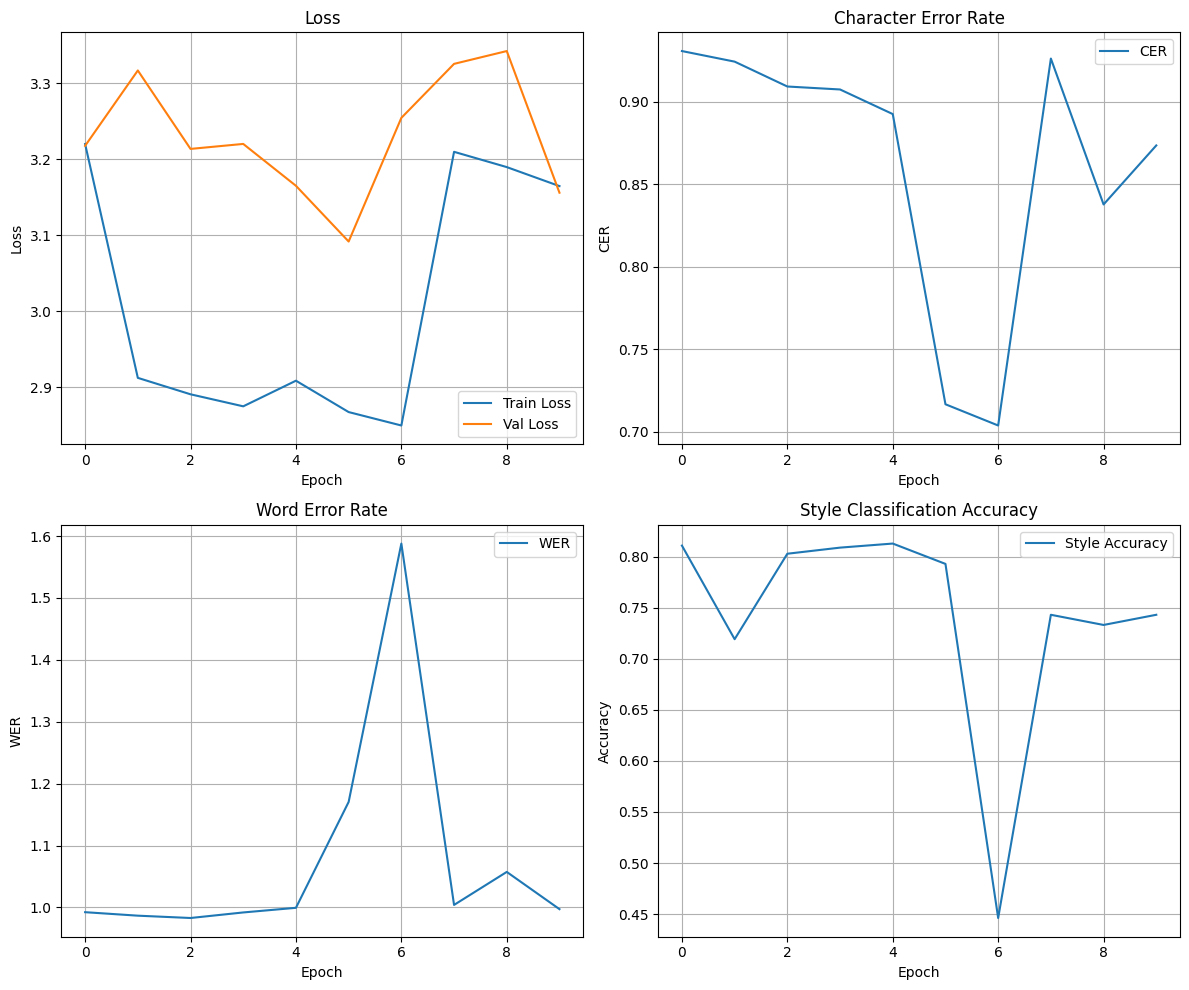


TEST METRICS — Loss: 3.0605, CER: 0.9762, WER: 1.0000, StyleAcc: 0.7435


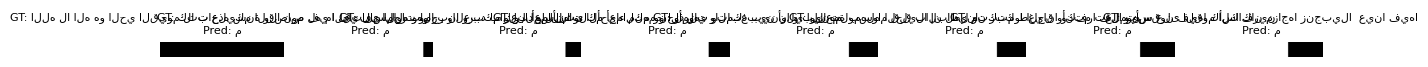

In [12]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))
        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths): return torch.clamp(widths,min=1)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        # Fix: input_lens must match sequence length of logits
        T = log_probs_main.size(0)  # time dimension
        input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP WITH HISTORY TRACKING ======================
EPOCHS = 10

# History dictionary to store metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "val_cer": [],
    "val_wer": [],
    "val_style_acc": []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            # Input lengths must match time dimension
            T = log_probs_main.size(0)
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    # Step scheduler
    scheduler.step()

    # Epoch train loss
    train_loss_epoch = running / max(1, seen)
    history["train_loss"].append(train_loss_epoch)

    # Validation metrics
    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.4f}, "
          f"WER {val_metrics['wer']:.4f}, StyleAcc {val_metrics['style_acc']:.4f}")

    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

# ====================== PLOTTING TRAINING CURVES ======================
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history["val_cer"], label="CER")
plt.title("Character Error Rate")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history["val_wer"], label="WER")
plt.title("Word Error Rate")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history["val_style_acc"], label="Style Accuracy")
plt.title("Style Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== TEST EVALUATION ======================
test_metrics = evaluate(model, test_loader)
print(f"\nTEST METRICS — Loss: {test_metrics['loss']:.4f}, CER: {test_metrics['cer']:.4f}, "
      f"WER: {test_metrics['wer']:.4f}, StyleAcc: {test_metrics['style_acc']:.4f}")

# ====================== QUALITATIVE SAMPLES ======================
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)
    with torch.no_grad():
        ctc_logits, _, _ = model(imgs)
    preds = greedy_decode_ctc(ctc_logits, widths)
    plt.figure(figsize=(15,3))
    for i in range(min(k,len(preds))):
        plt.subplot(1,k,i+1)
        plt.imshow(imgs[i,0].cpu(), cmap='gray')
        plt.title(f"GT: {label_strs[i]}\nPred: {preds[i]}", fontsize=8)
        plt.axis('off')
    plt.show()

show_samples(model, test_loader, k=8)




TRAINING
Device: cuda | GPU: 0.94/2.29/15.8GB

Epochs=100, Batch=32, Steps/epoch=126


Epoch 01:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 01/100 | train_loss=5.7129 | val_loss=3.0879 | CER=0.8242 | WER=0.9918 | StyleAcc=0.743 | 115.8s
  ✓ New best CER=0.8242 saved to checkpoints/ocr_december_best.pt


Epoch 02:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 02/100 | train_loss=5.0520 | val_loss=3.2263 | CER=0.8237 | WER=0.9816 | StyleAcc=0.743 | 115.4s
  ✓ New best CER=0.8237 saved to checkpoints/ocr_december_best.pt


Epoch 03:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 03/100 | train_loss=4.4408 | val_loss=3.1087 | CER=0.7152 | WER=1.3616 | StyleAcc=0.743 | 115.8s
  ✓ New best CER=0.7152 saved to checkpoints/ocr_december_best.pt


Epoch 04:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 04/100 | train_loss=4.1008 | val_loss=3.2298 | CER=0.7987 | WER=1.3089 | StyleAcc=0.743 | 115.8s


Epoch 05:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 05/100 | train_loss=3.9722 | val_loss=3.0921 | CER=0.7744 | WER=1.2531 | StyleAcc=0.745 | 115.6s


Epoch 06:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 06/100 | train_loss=3.9309 | val_loss=3.0891 | CER=0.7057 | WER=1.2087 | StyleAcc=0.743 | 115.8s
  ✓ New best CER=0.7057 saved to checkpoints/ocr_december_best.pt


Epoch 07:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 07/100 | train_loss=3.8343 | val_loss=3.1244 | CER=0.7283 | WER=1.3963 | StyleAcc=0.743 | 115.6s


Epoch 08:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 08/100 | train_loss=3.7560 | val_loss=3.1587 | CER=0.7746 | WER=1.3302 | StyleAcc=0.743 | 114.8s


Epoch 09:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 09/100 | train_loss=3.6984 | val_loss=3.2049 | CER=0.7709 | WER=1.3011 | StyleAcc=0.743 | 113.8s


Epoch 10:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/100 | train_loss=3.8032 | val_loss=3.1561 | CER=0.7768 | WER=1.2573 | StyleAcc=0.743 | 113.7s


Epoch 11:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/100 | train_loss=3.6557 | val_loss=3.1654 | CER=0.7302 | WER=1.3223 | StyleAcc=0.743 | 113.5s


Epoch 12:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/100 | train_loss=3.6766 | val_loss=3.1875 | CER=0.7780 | WER=1.2704 | StyleAcc=0.743 | 113.4s


Epoch 13:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/100 | train_loss=3.7103 | val_loss=3.1460 | CER=0.7779 | WER=1.2500 | StyleAcc=0.743 | 113.2s


Epoch 14:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/100 | train_loss=3.6447 | val_loss=3.2213 | CER=0.7704 | WER=1.2662 | StyleAcc=0.743 | 114.1s


Epoch 15:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15/100 | train_loss=3.6468 | val_loss=3.1362 | CER=0.7812 | WER=1.2590 | StyleAcc=0.743 | 114.3s


Epoch 16:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 16/100 | train_loss=3.6447 | val_loss=3.1694 | CER=0.7858 | WER=1.2406 | StyleAcc=0.743 | 115.3s


Epoch 17:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 17/100 | train_loss=3.6128 | val_loss=3.1711 | CER=0.7898 | WER=1.2628 | StyleAcc=0.743 | 115.7s


Epoch 18:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 18/100 | train_loss=3.6009 | val_loss=3.1788 | CER=0.7892 | WER=1.2690 | StyleAcc=0.743 | 115.6s


Epoch 19:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 19/100 | train_loss=3.6032 | val_loss=3.1314 | CER=0.7726 | WER=1.2222 | StyleAcc=0.743 | 116.6s


Epoch 20:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 20/100 | train_loss=3.5820 | val_loss=3.1533 | CER=0.7885 | WER=1.2640 | StyleAcc=0.743 | 115.3s


Epoch 21:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 21/100 | train_loss=3.5751 | val_loss=3.1492 | CER=0.7778 | WER=1.2457 | StyleAcc=0.743 | 114.2s


Epoch 22:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 22/100 | train_loss=3.5748 | val_loss=3.1554 | CER=0.7791 | WER=1.2567 | StyleAcc=0.743 | 113.8s


Epoch 23:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 23/100 | train_loss=3.5747 | val_loss=3.1495 | CER=0.7741 | WER=1.2592 | StyleAcc=0.743 | 113.9s


Epoch 24:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 24/100 | train_loss=3.5951 | val_loss=3.1529 | CER=0.7753 | WER=1.2457 | StyleAcc=0.743 | 114.2s


Epoch 25:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 25/100 | train_loss=3.5904 | val_loss=3.1464 | CER=0.7851 | WER=1.2460 | StyleAcc=0.743 | 114.9s


Epoch 26:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 26/100 | train_loss=3.5695 | val_loss=3.1588 | CER=0.7763 | WER=1.2421 | StyleAcc=0.743 | 113.8s


Epoch 27:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 27/100 | train_loss=3.5654 | val_loss=3.1414 | CER=0.7742 | WER=1.2489 | StyleAcc=0.743 | 115.3s


Epoch 28:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 28/100 | train_loss=3.5641 | val_loss=3.1681 | CER=0.7743 | WER=1.2421 | StyleAcc=0.743 | 114.7s


Epoch 29:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 29/100 | train_loss=3.5568 | val_loss=3.1426 | CER=0.7768 | WER=1.2587 | StyleAcc=0.743 | 113.3s


Epoch 30:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 30/100 | train_loss=3.5590 | val_loss=3.1390 | CER=0.7845 | WER=1.2561 | StyleAcc=0.743 | 114.4s


Epoch 31:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 31/100 | train_loss=3.5539 | val_loss=3.1428 | CER=0.7844 | WER=1.2564 | StyleAcc=0.743 | 115.3s


Epoch 32:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 32/100 | train_loss=3.5559 | val_loss=3.1483 | CER=0.7820 | WER=1.2433 | StyleAcc=0.743 | 114.2s


Epoch 33:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 33/100 | train_loss=3.5521 | val_loss=3.1452 | CER=0.7813 | WER=1.2497 | StyleAcc=0.743 | 113.6s


Epoch 34:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 34/100 | train_loss=3.5508 | val_loss=3.1423 | CER=0.7857 | WER=1.2526 | StyleAcc=0.743 | 115.2s


Epoch 35:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 35/100 | train_loss=3.5487 | val_loss=3.1556 | CER=0.7830 | WER=1.2495 | StyleAcc=0.743 | 114.7s


Epoch 36:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 36/100 | train_loss=3.5530 | val_loss=3.1518 | CER=0.7821 | WER=1.2484 | StyleAcc=0.743 | 113.0s


Epoch 37:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 37/100 | train_loss=3.5468 | val_loss=3.1474 | CER=0.7826 | WER=1.2478 | StyleAcc=0.743 | 113.4s


Epoch 38:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 38/100 | train_loss=3.5456 | val_loss=3.1455 | CER=0.7846 | WER=1.2452 | StyleAcc=0.743 | 114.6s


Epoch 39:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 39/100 | train_loss=3.5509 | val_loss=3.1459 | CER=0.7831 | WER=1.2460 | StyleAcc=0.743 | 115.2s


Epoch 40:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 40/100 | train_loss=3.5526 | val_loss=3.1477 | CER=0.7827 | WER=1.2465 | StyleAcc=0.743 | 114.2s


Epoch 41:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 41/100 | train_loss=3.5491 | val_loss=3.1465 | CER=0.7826 | WER=1.2477 | StyleAcc=0.743 | 114.8s


Epoch 42:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 42/100 | train_loss=3.5473 | val_loss=3.1452 | CER=0.7841 | WER=1.2494 | StyleAcc=0.743 | 114.7s


Epoch 43:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 43/100 | train_loss=3.5478 | val_loss=3.1441 | CER=0.7827 | WER=1.2492 | StyleAcc=0.743 | 113.9s


Epoch 44:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 44/100 | train_loss=3.5542 | val_loss=3.1483 | CER=0.7815 | WER=1.2466 | StyleAcc=0.743 | 113.2s


Epoch 45:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 45/100 | train_loss=3.5497 | val_loss=3.1469 | CER=0.7821 | WER=1.2402 | StyleAcc=0.743 | 113.7s


Epoch 46:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 46/100 | train_loss=3.5463 | val_loss=3.1399 | CER=0.7755 | WER=1.2446 | StyleAcc=0.743 | 114.4s


Epoch 47:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 47/100 | train_loss=3.5501 | val_loss=3.1455 | CER=0.7812 | WER=1.2437 | StyleAcc=0.743 | 113.3s


Epoch 48:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 48/100 | train_loss=3.5497 | val_loss=3.1271 | CER=0.7834 | WER=1.2412 | StyleAcc=0.743 | 113.1s


Epoch 49:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 49/100 | train_loss=3.5520 | val_loss=3.1442 | CER=0.7848 | WER=1.2488 | StyleAcc=0.743 | 114.2s


Epoch 50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 50/100 | train_loss=3.5526 | val_loss=3.1650 | CER=0.7763 | WER=1.2466 | StyleAcc=0.743 | 113.7s


Epoch 51:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 51/100 | train_loss=3.5481 | val_loss=3.1396 | CER=0.7745 | WER=1.2482 | StyleAcc=0.743 | 112.8s


Epoch 52:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 52/100 | train_loss=3.5510 | val_loss=3.1369 | CER=0.7799 | WER=1.2481 | StyleAcc=0.743 | 112.7s


Epoch 53:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 53/100 | train_loss=3.5510 | val_loss=3.1493 | CER=0.7802 | WER=1.2528 | StyleAcc=0.743 | 113.5s


Epoch 54:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 54/100 | train_loss=3.5554 | val_loss=3.1747 | CER=0.7897 | WER=1.2719 | StyleAcc=0.743 | 114.1s


Epoch 55:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 55/100 | train_loss=3.5705 | val_loss=3.1338 | CER=0.7764 | WER=1.2467 | StyleAcc=0.743 | 113.4s


Epoch 56:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 56/100 | train_loss=3.5631 | val_loss=3.1811 | CER=0.7738 | WER=1.2335 | StyleAcc=0.743 | 113.0s


Epoch 57:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 57/100 | train_loss=3.5767 | val_loss=3.1247 | CER=0.7587 | WER=1.2396 | StyleAcc=0.743 | 114.1s


Epoch 58:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 58/100 | train_loss=3.6182 | val_loss=3.1545 | CER=0.7637 | WER=1.2827 | StyleAcc=0.743 | 114.0s


Epoch 59:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 59/100 | train_loss=3.5777 | val_loss=3.1320 | CER=0.7609 | WER=1.2509 | StyleAcc=0.743 | 113.0s


Epoch 60:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 60/100 | train_loss=3.5580 | val_loss=3.1449 | CER=0.7586 | WER=1.2694 | StyleAcc=0.743 | 113.2s


Epoch 61:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 61/100 | train_loss=3.5715 | val_loss=3.1704 | CER=0.7844 | WER=1.2352 | StyleAcc=0.743 | 114.5s


Epoch 62:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 62/100 | train_loss=3.5652 | val_loss=3.1674 | CER=0.7667 | WER=1.2653 | StyleAcc=0.743 | 114.0s


Epoch 63:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 63/100 | train_loss=3.7229 | val_loss=3.0974 | CER=0.7325 | WER=1.1739 | StyleAcc=0.743 | 113.1s


Epoch 64:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 64/100 | train_loss=3.6024 | val_loss=3.1582 | CER=0.7943 | WER=1.2495 | StyleAcc=0.743 | 113.5s


Epoch 65:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 65/100 | train_loss=3.5657 | val_loss=3.1613 | CER=0.7936 | WER=1.2577 | StyleAcc=0.743 | 117.9s


Epoch 66:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 66/100 | train_loss=3.7186 | val_loss=3.1821 | CER=0.7802 | WER=1.3491 | StyleAcc=0.743 | 115.6s


Epoch 67:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 67/100 | train_loss=3.6367 | val_loss=3.1157 | CER=0.7691 | WER=1.2765 | StyleAcc=0.743 | 114.4s


Epoch 68:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 68/100 | train_loss=3.6071 | val_loss=3.1701 | CER=0.7690 | WER=1.2408 | StyleAcc=0.743 | 114.9s


Epoch 69:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 69/100 | train_loss=3.6172 | val_loss=3.1662 | CER=0.7876 | WER=1.2619 | StyleAcc=0.743 | 115.2s


Epoch 70:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 70/100 | train_loss=3.5922 | val_loss=3.2197 | CER=0.7709 | WER=1.2221 | StyleAcc=0.743 | 114.7s


Epoch 71:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 71/100 | train_loss=3.7057 | val_loss=3.1781 | CER=0.7818 | WER=1.2715 | StyleAcc=0.743 | 113.9s


Epoch 72:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 72/100 | train_loss=3.6976 | val_loss=3.1599 | CER=0.7723 | WER=1.2581 | StyleAcc=0.743 | 115.7s


Epoch 73:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 73/100 | train_loss=3.6368 | val_loss=3.1652 | CER=0.7668 | WER=1.2460 | StyleAcc=0.743 | 115.3s


Epoch 74:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 74/100 | train_loss=3.7077 | val_loss=3.2139 | CER=0.8030 | WER=1.2799 | StyleAcc=0.743 | 114.5s


Epoch 75:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 75/100 | train_loss=3.8084 | val_loss=3.2173 | CER=0.7159 | WER=1.4560 | StyleAcc=0.743 | 115.1s


Epoch 76:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 76/100 | train_loss=3.6883 | val_loss=3.1713 | CER=0.7664 | WER=1.3527 | StyleAcc=0.743 | 115.5s


Epoch 77:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 77/100 | train_loss=3.7507 | val_loss=3.2016 | CER=0.7652 | WER=1.3770 | StyleAcc=0.743 | 115.5s


Epoch 78:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 78/100 | train_loss=3.9457 | val_loss=3.1604 | CER=0.7342 | WER=1.5328 | StyleAcc=0.743 | 114.1s


Epoch 79:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 79/100 | train_loss=3.9439 | val_loss=3.1720 | CER=0.7305 | WER=1.4334 | StyleAcc=0.743 | 114.9s


Epoch 80:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 80/100 | train_loss=4.6127 | val_loss=3.0685 | CER=0.7840 | WER=1.0798 | StyleAcc=0.743 | 115.3s


Epoch 81:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 81/100 | train_loss=4.0767 | val_loss=3.1952 | CER=0.7995 | WER=1.6450 | StyleAcc=0.743 | 115.2s


Epoch 82:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 82/100 | train_loss=3.9779 | val_loss=3.1702 | CER=0.7683 | WER=1.4105 | StyleAcc=0.743 | 113.6s


Epoch 83:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 83/100 | train_loss=3.9479 | val_loss=3.2039 | CER=0.7363 | WER=1.5485 | StyleAcc=0.739 | 114.2s


Epoch 84:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 84/100 | train_loss=3.9974 | val_loss=3.2265 | CER=0.7187 | WER=1.2344 | StyleAcc=0.743 | 114.8s


Epoch 85:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 85/100 | train_loss=3.9405 | val_loss=3.2150 | CER=0.7093 | WER=1.3419 | StyleAcc=0.743 | 115.4s


Epoch 86:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 86/100 | train_loss=4.4166 | val_loss=3.3116 | CER=0.8130 | WER=1.0500 | StyleAcc=0.743 | 114.5s


Epoch 87:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 87/100 | train_loss=4.0025 | val_loss=3.1182 | CER=0.7115 | WER=1.4312 | StyleAcc=0.743 | 115.4s


Epoch 88:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 88/100 | train_loss=3.8813 | val_loss=3.1751 | CER=0.7659 | WER=1.3690 | StyleAcc=0.743 | 115.2s


Epoch 89:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 89/100 | train_loss=3.9688 | val_loss=3.1222 | CER=0.7910 | WER=1.0051 | StyleAcc=0.743 | 119.6s


Epoch 90:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 90/100 | train_loss=3.9469 | val_loss=3.1721 | CER=0.7304 | WER=1.1288 | StyleAcc=0.743 | 120.1s


Epoch 91:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 91/100 | train_loss=3.9299 | val_loss=3.2062 | CER=0.7192 | WER=1.4641 | StyleAcc=0.743 | 119.7s


Epoch 92:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 92/100 | train_loss=3.9714 | val_loss=3.1746 | CER=0.6976 | WER=1.2525 | StyleAcc=0.743 | 119.4s
  ✓ New best CER=0.6976 saved to checkpoints/ocr_december_best.pt


Epoch 93:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 93/100 | train_loss=3.9428 | val_loss=3.1340 | CER=0.7121 | WER=1.4619 | StyleAcc=0.743 | 121.1s


Epoch 94:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 94/100 | train_loss=4.3055 | val_loss=3.2070 | CER=0.7542 | WER=1.0375 | StyleAcc=0.743 | 120.6s


Epoch 95:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 95/100 | train_loss=4.0950 | val_loss=3.0838 | CER=0.7524 | WER=1.0054 | StyleAcc=0.743 | 120.7s


Epoch 96:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 96/100 | train_loss=4.2555 | val_loss=3.0802 | CER=0.6962 | WER=1.0879 | StyleAcc=0.743 | 119.6s
  ✓ New best CER=0.6962 saved to checkpoints/ocr_december_best.pt


Epoch 97:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 97/100 | train_loss=4.1495 | val_loss=3.2509 | CER=0.7631 | WER=1.7486 | StyleAcc=0.743 | 116.7s


Epoch 98:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 98/100 | train_loss=4.1494 | val_loss=3.0223 | CER=0.7139 | WER=1.1862 | StyleAcc=0.743 | 116.2s


Epoch 99:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 99/100 | train_loss=4.0226 | val_loss=3.1515 | CER=0.7016 | WER=1.2879 | StyleAcc=0.743 | 116.1s


Epoch 100:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 100/100 | train_loss=4.0410 | val_loss=3.1512 | CER=0.7229 | WER=1.5056 | StyleAcc=0.743 | 115.1s


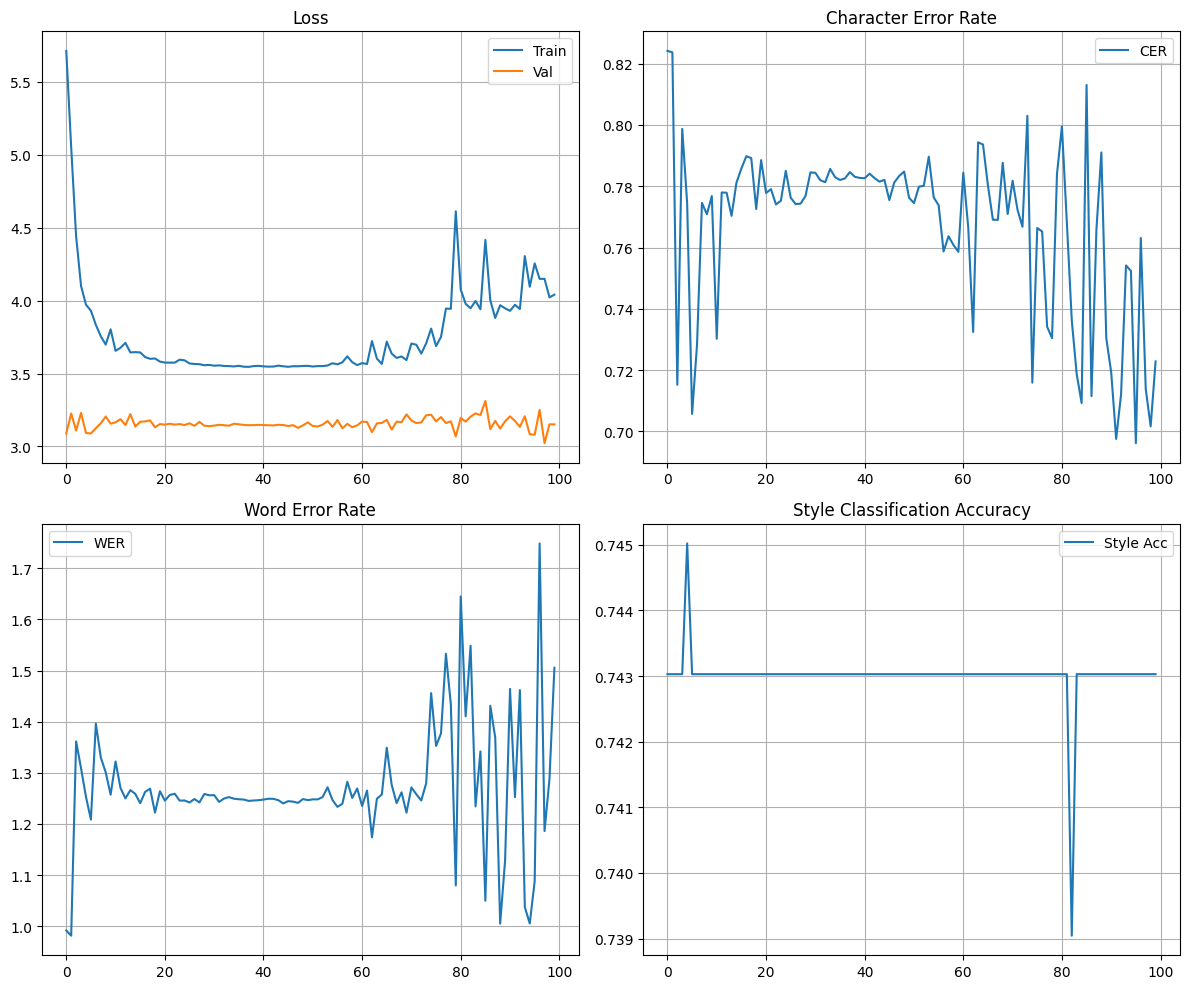


TEST EVALUATION
TEST — CER=0.6895 | WER=0.9927 | Style Acc=0.7435


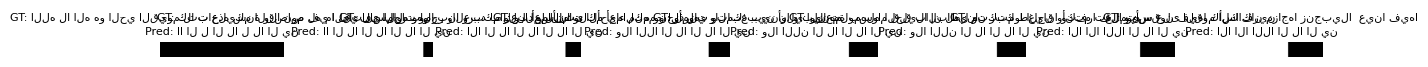

In [16]:
# ====================== Training Loop ======================
from pathlib import Path
import matplotlib.pyplot as plt
import gc, time

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "ocr_december_best.pt"

history = {
    "train_loss": [], "val_loss": [],
    "val_cer": [], "val_wer": [], "val_style_acc": []
}

best_cer = float('inf')
EPOCHS = 100

MAX_NORM = 5.0
AUX_CTC_WEIGHT = 0.3
LAMBDA_CLS = 0.2

print("\n" + "="*60)
print("TRAINING")
print("="*60)
print(f"Device: {DEVICE} | {gpu_mem()}\n")
steps_per_epoch = len(train_loader)
print(f"Epochs={EPOCHS}, Batch={BATCH_SIZE}, Steps/epoch={steps_per_epoch}")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    seen = 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False)
    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        label_lens = label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cuda():
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)
            log_probs_aux = ctc_logits_aux.log_softmax(2)

            T = log_probs_main.size(0)  # time dimension
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc_main = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens)
            loss_ctc_aux  = ctc_loss_fn(log_probs_aux.float(), labels_concat, input_lens, label_lens)
            loss_cls = cls_loss_fn(style_logits, style_idxs)

            loss = loss_ctc_main + AUX_CTC_WEIGHT * loss_ctc_aux + LAMBDA_CLS * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(avg=f"{running_loss / max(1, seen):.4f}")

    scheduler.step()
    train_loss = running_loss / max(1, seen)
    history["train_loss"].append(train_loss)

    # ===== Validation =====
    val_metrics = evaluate(model, val_loader)
    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"val_loss={val_metrics['loss']:.4f} | CER={val_metrics['cer']:.4f} | "
          f"WER={val_metrics['wer']:.4f} | StyleAcc={val_metrics['style_acc']:.3f} | {dt:.1f}s")

    # Save best model
    if val_metrics["cer"] < best_cer:
        best_cer = val_metrics["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "charset": charset,
            "style_names": style_names
        }, BEST_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved to {BEST_PATH}")

    # Memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

# ===== Training Curves =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss"); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer"], label="CER")
axes[0, 1].set_title("Character Error Rate"); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer"], label="WER")
axes[1, 0].set_title("Word Error Rate"); axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc"], label="Style Acc")
axes[1, 1].set_title("Style Classification Accuracy"); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ===== Test Evaluation =====
print("\nTEST EVALUATION")
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()
test_metrics = evaluate(model, test_loader)
print(f"TEST — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | Style Acc={test_metrics['style_acc']:.4f}")

# ===== Show Qualitative Samples =====
show_samples(model, test_loader, k=8)


Device: cuda
Charset size: 49


/tmp/ipython-input-3164955421.py:143: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-3164955421.py:145: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-3164955421.py:146: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3164955421.py:148: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=

Epoch 01:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 1: Loss 2.9858, CER 0.6845, WER 1.0118, StyleAcc 0.6016


Epoch 02:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 2: Loss 2.9323, CER 0.6744, WER 1.0617, StyleAcc 0.6076


Epoch 03:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 3: Loss 2.9392, CER 0.6985, WER 1.0596, StyleAcc 0.5598


Epoch 04:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 4: Loss 3.1383, CER 0.6645, WER 1.0072, StyleAcc 0.3088


Epoch 05:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 5: Loss 2.9320, CER 0.6564, WER 0.9971, StyleAcc 0.6653


Epoch 06:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 6: Loss 3.0948, CER 0.6588, WER 1.0028, StyleAcc 0.1713


Epoch 07:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 7: Loss 3.1212, CER 0.6667, WER 1.1093, StyleAcc 0.0159


Epoch 08:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 8: Loss nan, CER 1.0000, WER 1.0000, StyleAcc 0.0458


Epoch 09:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 9: Loss nan, CER 1.0000, WER 1.0000, StyleAcc 0.0458


Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

VAL Epoch 10: Loss nan, CER 1.0000, WER 1.0000, StyleAcc 0.0458


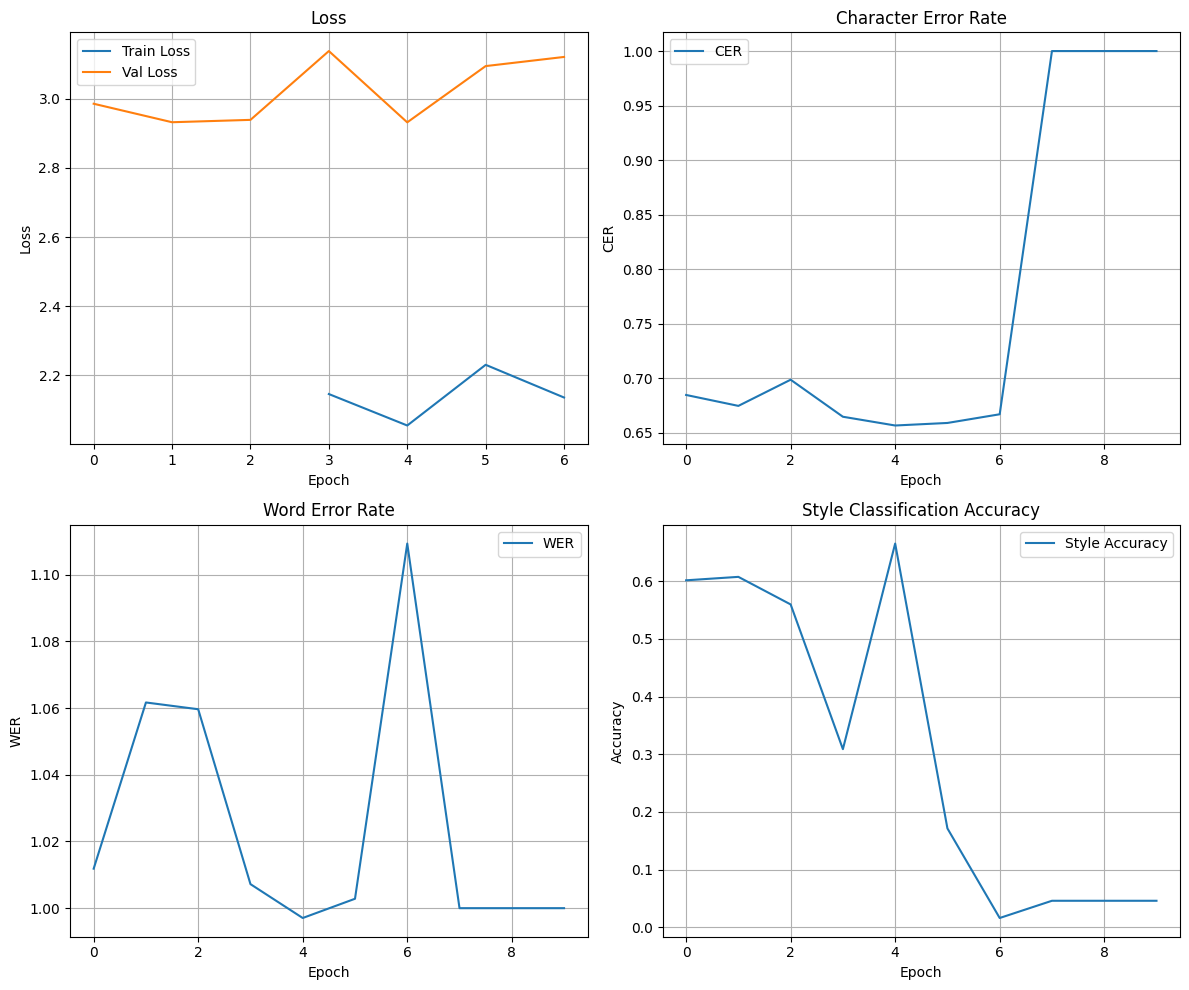


TEST METRICS — Loss: nan, CER: 1.0000, WER: 1.0000, StyleAcc: 0.0477


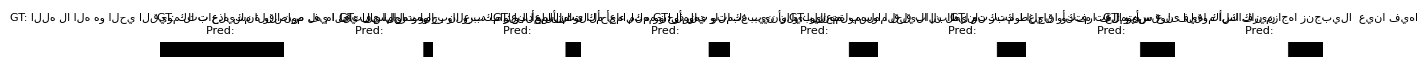

In [25]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Augmented_HICMA")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))
        MAX_WIDTH = 600
        if img.shape[1] > MAX_WIDTH:
          img = cv2.resize(img, (MAX_WIDTH, H_TARGET), interpolation=cv2.INTER_AREA)
        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths):
    return torch.clamp(widths // 4, min=1, max=64)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        T = log_probs_main.size(0)
        input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP WITH HISTORY TRACKING ======================
EPOCHS = 10

# History dictionary to store metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "val_cer": [],
    "val_wer": [],
    "val_style_acc": []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            T = log_probs_main.size(0)
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    # Step scheduler
    scheduler.step()

    # Epoch train loss
    train_loss_epoch = running / max(1, seen)
    history["train_loss"].append(train_loss_epoch)

    # Validation metrics
    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.4f}, "
          f"WER {val_metrics['wer']:.4f}, StyleAcc {val_metrics['style_acc']:.4f}")

    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

# ====================== PLOTTING TRAINING CURVES ======================
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history["val_cer"], label="CER")
plt.title("Character Error Rate")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history["val_wer"], label="WER")
plt.title("Word Error Rate")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history["val_style_acc"], label="Style Accuracy")
plt.title("Style Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== TEST EVALUATION ======================
test_metrics = evaluate(model, test_loader)
print(f"\nTEST METRICS — Loss: {test_metrics['loss']:.4f}, CER: {test_metrics['cer']:.4f}, "
      f"WER: {test_metrics['wer']:.4f}, StyleAcc: {test_metrics['style_acc']:.4f}")

# ====================== QUALITATIVE SAMPLES ======================
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)
    with torch.no_grad():
        ctc_logits, _, _ = model(imgs)
    preds = greedy_decode_ctc(ctc_logits, widths)
    plt.figure(figsize=(15,3))
    for i in range(min(k,len(preds))):
        plt.subplot(1,k,i+1)
        plt.imshow(imgs[i,0].cpu(), cmap='gray')
        plt.title(f"GT: {label_strs[i]}\nPred: {preds[i]}", fontsize=8)
        plt.axis('off')
    plt.show()

show_samples(model, test_loader, k=8)



In [26]:


# ====================== Training Loop ======================
from pathlib import Path
import matplotlib.pyplot as plt
import gc, time

SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "ocr_december_best_aug.pt"

history = {
    "train_loss": [], "val_loss": [],
    "val_cer": [], "val_wer": [], "val_style_acc": []
}

best_cer = float('inf')
EPOCHS = 50

MAX_NORM = 5.0
AUX_CTC_WEIGHT = 0.3
LAMBDA_CLS = 0.2

print("\n" + "="*60)
print("TRAINING")
print("="*60)
print(f"Device: {DEVICE} | {gpu_mem()}\n")
steps_per_epoch = len(train_loader)
print(f"Epochs={EPOCHS}, Batch={BATCH_SIZE}, Steps/epoch={steps_per_epoch}")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    seen = 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False)
    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        label_lens = label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cuda():
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)
            log_probs_aux = ctc_logits_aux.log_softmax(2)

            T = log_probs_main.size(0)  # time dimension
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc_main = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens)
            loss_ctc_aux  = ctc_loss_fn(log_probs_aux.float(), labels_concat, input_lens, label_lens)
            loss_cls = cls_loss_fn(style_logits, style_idxs)

            loss = loss_ctc_main + AUX_CTC_WEIGHT * loss_ctc_aux + LAMBDA_CLS * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(avg=f"{running_loss / max(1, seen):.4f}")

    scheduler.step()
    train_loss = running_loss / max(1, seen)
    history["train_loss"].append(train_loss)

    # ===== Validation =====
    val_metrics = evaluate(model, val_loader)
    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"val_loss={val_metrics['loss']:.4f} | CER={val_metrics['cer']:.4f} | "
          f"WER={val_metrics['wer']:.4f} | StyleAcc={val_metrics['style_acc']:.3f} | {dt:.1f}s")

    # Save best model
    if val_metrics["cer"] < best_cer:
        best_cer = val_metrics["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "charset": charset,
            "style_names": style_names
        }, BEST_PATH)
        print(f"  ✓ New best CER={best_cer:.4f} saved to {BEST_PATH}")

    # Memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

# ===== Training Curves =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss"); axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer"], label="CER")
axes[0, 1].set_title("Character Error Rate"); axes[0, 1].legend(); axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer"], label="WER")
axes[1, 0].set_title("Word Error Rate"); axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc"], label="Style Acc")
axes[1, 1].set_title("Style Classification Accuracy"); axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(SAVE_DIR / "training_curves.png", dpi=150)
plt.show()

# ===== Test Evaluation =====
print("\nTEST EVALUATION")
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()
test_metrics = evaluate(model, test_loader)
print(f"TEST — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | Style Acc={test_metrics['style_acc']:.4f}")

# ===== Show Qualitative Samples =====
@torch.no_grad()
def show_samples(model, loader, k=8, downsample_factor=4):
    """
    Fixed qualitative sample display:
     - Un-normalizes images before imshow
     - Uses correct CTC input lengths (widths // downsample_factor)
     - Shows style prediction and GT/Pred text with match marker
    """
    model.eval()

    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    B = imgs.size(0)
    imgs = imgs.to(DEVICE)

    # forward
    with autocast_cuda():
        ctc_logits_main, _, style_logits = model(imgs)

    # compute correct input lengths for CTC decoding (and for greedy decoder)
    # clamp to at least 1
    input_lens = torch.clamp((widths.to(DEVICE) // downsample_factor), min=1)

    # decode predictions
    preds = greedy_decode_ctc(ctc_logits_main, input_lens)
    style_pred = style_logits.softmax(1).argmax(1).cpu().tolist()

    n_show = min(k, B)

    # layout
    fig, axes = plt.subplots(n_show, 1, figsize=(14, 2.6 * n_show))
    if n_show == 1:
        axes = [axes]

    for i in range(n_show):
        # un-normalize image for display
        im = imgs[i, 0].cpu().numpy()
        im = np.clip(im * STD + MEAN, 0, 1)

        gt_style = style_names_b[i]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i] if i < len(preds) else ""
        match = "✓" if gt_text == pr_text else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Style: {gt_style} → {pr_style} | GT: {gt_text} | PR: {pr_text} {match}", fontsize=10)

    plt.tight_layout()
    out_path = SAVE_DIR / "sample_predictions_fixed.png" if 'SAVE_DIR' in globals() else Path("./sample_predictions_fixed.png")
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved to {out_path}")

# call it
show_samples(model, test_loader, k=8)



TRAINING
Device: cuda | GPU: 2.91/5.09/15.8GB

Epochs=50, Batch=32, Steps/epoch=625


Epoch 01:   0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# %% FULL OCR TRAINING SCRIPT FOR Preprocessed_HICMA DATASET

# ====================== Setup ======================
import os, time, random, unicodedata, gc
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision import models
from tqdm.auto import tqdm

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

def human(n): return f"{n:,}"

def autocast_cuda():
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.bfloat16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/HICMA_Plus_Synthetic")

TRAIN_DIR = BASE_DIR / "train/images"
VAL_DIR   = BASE_DIR / "val/images"
TEST_DIR  = BASE_DIR / "test/images"

TRAIN_LABELS = BASE_DIR / "train_labels.csv"
VAL_LABELS   = BASE_DIR / "val_labels.csv"
TEST_LABELS  = BASE_DIR / "test_labels.csv"

assert TRAIN_LABELS.exists() and VAL_LABELS.exists() and TEST_LABELS.exists(), "Label CSVs not found!"

# ====================== Load CSVs & Normalize ======================
def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df_train = pd.read_csv(TRAIN_LABELS)
df_val   = pd.read_csv(VAL_LABELS)
df_test  = pd.read_csv(TEST_LABELS)

for df in [df_train, df_val, df_test]:
    df['label'] = df['label'].astype(str).apply(normalize_label)
    df['img_path'] = df['img_name'].apply(lambda x: str((TRAIN_DIR if 'train' in df.columns else VAL_DIR) / x))

# ====================== Charset ======================
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])
char_counts = Counter()
for s in all_labels:
    for ch in s:
        char_counts[ch] += 1

charset = ['<BLANK>'] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
print(f"Charset size: {len(charset)}")

# ====================== Style Classes ======================
all_classes = pd.concat([df_train['class'], df_val['class'], df_test['class']]).fillna("Unknown")
style_names = sorted(all_classes.unique())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}

# ====================== Label Encoding ======================
RTL_REVERSE = True
def encode_label(text, rtl_reverse=True):
    if rtl_reverse: text = text[::-1]
    return [char2idx[ch] for ch in text if ch in char2idx and ch != '<BLANK>']

for df in [df_train, df_val, df_test]:
    df['enc_len'] = df['label'].apply(lambda s: len(encode_label(s, RTL_REVERSE)))
    df = df[df['enc_len'] > 0].reset_index(drop=True)

# ====================== Image Processing ======================
H_TARGET = 64
W_MAX = 512
MEAN, STD = 0.5, 0.5
MIN_PX_PER_CHAR = 8

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def decode_pred(indices, rtl_reverse=RTL_REVERSE):
    res, prev = [], None
    for idx in indices:
        if idx != BLANK_IDX and idx != prev:
            res.append(idx2char[idx])
        prev = idx
    s = "".join(res)
    return s[::-1] if rtl_reverse else s

def resize_keep_ar_enforced(gray, h=H_TARGET, label_len=0, min_px_per_char=MIN_PX_PER_CHAR, min_w=16, w_max=W_MAX):
    h0, w0 = gray.shape[:2]
    base_scale = h / float(h0)
    req_w = max(min_w, min(w_max, label_len * min_px_per_char))
    scale_w = req_w / float(w0)
    scale = max(base_scale, scale_w)
    new_w = int(np.clip(np.ceil(w0 * scale), min_w, w_max))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    return cv2.resize(gray, (new_w, h), interpolation=interp)

def pad_width_to_multiple(img, multiple=4, pad_value=255):
    h, w = img.shape
    pad_w = (multiple - (w % multiple)) % multiple
    if pad_w == 0: return img
    return cv2.copyMakeBorder(img, 0, 0, 0, pad_w, cv2.BORDER_CONSTANT, value=pad_value)

# ====================== Augmentations ======================
AUG_P = 0.35
train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P*0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P*0.8),
    A.CoarseDropout(max_holes=3, max_height=8, max_width=20, fill_value=255, p=AUG_P*0.5),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P*0.8)
])

def stroke_thickness_jitter(img, p=0.4):
    if random.random() > p: return img
    k = random.choice([1,1,2])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*k+1,2*k+1))
    return cv2.erode(img, kernel) if random.random()<0.5 else cv2.dilate(img, kernel)

def cutout_stripes(img, p=0.25):
    if random.random() > p: return img
    h,w = img.shape
    n = random.randint(1,2)
    for _ in range(n):
        stripe_w = max(2,int(random.random()*max(3,w*0.1)))
        x0 = random.randint(0,max(0,w-stripe_w))
        img[:,x0:x0+stripe_w] = 255
    return img

def apply_train_aug(img):
    img = stroke_thickness_jitter(img)
    img = cutout_stripes(img)
    return train_aug(image=img)['image']

# ====================== Dataset ======================
class OCRDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.training = training
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET,64),dtype=np.uint8)*255
        label_ids = encode_label(row['label'])
        style_idx = style2idx[row['class']]
        img = resize_keep_ar_enforced(img,H_TARGET,label_len=len(label_ids))
        MAX_WIDTH = 600
        if img.shape[1] > MAX_WIDTH:
          img = cv2.resize(img, (MAX_WIDTH, H_TARGET), interpolation=cv2.INTER_AREA)
        if self.training: img = apply_train_aug(img)
        img = pad_width_to_multiple(img)
        img = (img.astype(np.float32)/255.0 - MEAN)/STD
        img_t = torch.from_numpy(img)[None,...]
        return img_t, torch.tensor(label_ids,dtype=torch.long), row['label'], torch.tensor(style_idx), row['class'], img_t.shape[-1]

def collate_fn(batch):
    batch = sorted(batch,key=lambda x:x[-1],reverse=True)
    imgs, labels, label_strs, style_idxs, style_names_b, widths = zip(*batch)
    max_w = max(widths)
    bsz = len(imgs)
    padded = torch.full((bsz,1,H_TARGET,max_w),(0.0-MEAN)/STD,dtype=torch.float32)
    for i,im in enumerate(imgs):
        w = im.shape[-1]
        padded[i,:,:, :w] = im
    label_lens = torch.tensor([len(l) for l in labels],dtype=torch.long)
    labels_concat = torch.cat(labels,dim=0) if len(labels) else torch.tensor([],dtype=torch.long)
    return padded, labels_concat, label_lens, label_strs, torch.stack(style_idxs), style_names_b, torch.tensor(widths,dtype=torch.long)

# ====================== Model ======================
try: _IMAGENET_WEIGHTS = models.ResNet34_Weights.IMAGENET1K_V1
except: _IMAGENET_WEIGHTS = "IMAGENET1K_V1"

class ResNet34OCRBackbone(nn.Module):
    def __init__(self,in_ch=1):
        super().__init__()
        try: m=models.resnet34(weights=_IMAGENET_WEIGHTS)
        except: m=models.resnet34(pretrained=True)
        w=m.conv1.weight.data
        new_w=w.mean(dim=1,keepdim=True)
        m.conv1 = nn.Conv2d(in_ch,64,kernel_size=7,stride=(2,1),padding=3,bias=False)
        with torch.no_grad(): m.conv1.weight.copy_(new_w)
        m.maxpool = nn.MaxPool2d(3,stride=(2,1),padding=1)
        self.stem = nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = m.layer1, m.layer2, m.layer3, m.layer4
        self.out = nn.AdaptiveAvgPool2d((1,None))
    def forward(self,x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        fmap = x
        seq = self.out(fmap).squeeze(2).permute(2,0,1)
        return seq,fmap

class TemporalGLUBlock(nn.Module):
    def __init__(self,c=512,k=5,dilation=1,p=0.1):
        super().__init__()
        pad = (k-1)//2*dilation
        self.conv=nn.Conv1d(c,2*c,kernel_size=k,padding=pad,dilation=dilation)
        self.glu = nn.GLU(dim=1)
        self.drop=nn.Dropout(p)
        self.res=nn.Conv1d(c,c,kernel_size=1)
    def forward(self,x):
        x = x.permute(1,2,0)
        y = self.glu(self.conv(x))
        y = self.drop(y)+self.res(x)
        return y.permute(2,0,1)

class BiLSTMStack(nn.Module):
    def __init__(self,in_dim,hidden=256,num_layers=2,dropout=0.25):
        super().__init__()
        layers=[]
        for i in range(num_layers):
            inp=in_dim if i==0 else hidden*2
            layers.append(nn.LSTM(inp,hidden,bidirectional=True,batch_first=False))
            layers.append(nn.Dropout(dropout))
        self.layers=nn.ModuleList(layers)
    def forward(self,x):
        for i in range(0,len(self.layers),2):
            x,_=self.layers[i](x)
            x=self.layers[i+1](x)
        return x

class OCR_MultiTask_V3(nn.Module):
    def __init__(self,num_chars,num_styles,blank_idx=0,aux_weight=0.3):
        super().__init__()
        self.backbone = ResNet34OCRBackbone()
        self.tcn1 = TemporalGLUBlock(512,5,1,0.1)
        self.tcn2 = TemporalGLUBlock(512,5,2,0.1)
        self.lstm = BiLSTMStack(512,256,2,0.25)
        self.ctc_head_main = nn.Linear(512,num_chars)
        self.ctc_head_aux = nn.Linear(512,num_chars)
        self.style_head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
                                        nn.Dropout(0.25),
                                        nn.Linear(512,max(256,num_styles*4)), nn.ReLU(True),
                                        nn.Linear(max(256,num_styles*4),num_styles))
        self.blank_idx = blank_idx
        self.aux_weight = aux_weight
        with torch.no_grad():
            self.ctc_head_main.bias.zero_(); self.ctc_head_main.bias[blank_idx]=-2.0
            self.ctc_head_aux.bias.zero_(); self.ctc_head_aux.bias[blank_idx]=-2.0
    def forward(self,x):
        seq,fmap=self.backbone(x)
        tcn_out=self.tcn2(self.tcn1(seq))
        lstm_out=self.lstm(tcn_out)
        ctc_logits_main=self.ctc_head_main(lstm_out)
        ctc_logits_aux=self.ctc_head_aux(tcn_out)
        style_logits=self.style_head(fmap.detach())
        return ctc_logits_main,ctc_logits_aux,style_logits

# ====================== Dataloaders ======================
BATCH_SIZE=32
train_ds = OCRDataset(df_train,training=True)
val_ds   = OCRDataset(df_val,training=False)
test_ds  = OCRDataset(df_test,training=False)

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4)
val_loader   = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)
test_loader  = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn,num_workers=4)

# ====================== Loss & Optimizer ======================
num_chars = len(charset)
num_styles = len(style_names)
model = OCR_MultiTask_V3(num_chars,num_styles,blank_idx=BLANK_IDX).to(DEVICE)

ctc_loss_fn = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=1e-6)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

# ====================== Training & Evaluation Functions ======================
def ctc_time_lengths(widths):
    return torch.clamp(widths // 4, min=1, max=64)

def greedy_decode_ctc(logits,widths):
    max_idxs=logits.softmax(-1).argmax(-1)
    T,B = max_idxs.shape
    res=[]
    for b in range(B):
        L=int(widths[b])
        seq=max_idxs[:L,b].tolist()
        res.append(decode_pred(seq))
    return res

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); tot_loss=tot_cer=tot_wer=0; cnt=0; cls_correct=cls_total=0
    for imgs,labels_concat,label_lens,label_strs,style_idxs,style_names_b,widths in loader:
        imgs,style_idxs,label_lens = imgs.to(DEVICE),style_idxs.to(DEVICE),label_lens.to(DEVICE)
        input_lens = ctc_time_lengths(widths).to(DEVICE)
        ctc_logits_main,ctc_logits_aux,style_logits=model(imgs)
        log_probs_main=ctc_logits_main.log_softmax(2)
        T = log_probs_main.size(0)
        input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)
        loss_ctc = ctc_loss_fn(log_probs_main.float(),labels_concat.to(DEVICE),input_lens,label_lens) if len(labels_concat)>0 else 0
        loss_cls = cls_loss_fn(style_logits, style_idxs)
        loss = loss_ctc + 0.2*loss_cls
        tot_loss += loss.item()*imgs.size(0); cnt+=imgs.size(0)
        preds=greedy_decode_ctc(ctc_logits_main,widths)
        for gt,pr in zip(label_strs,preds):
            tot_cer += editdistance.eval(gt,pr)/max(1,len(gt))
            tot_wer += editdistance.eval(gt.split(),pr.split())/max(1,len(gt.split()))
        cls_correct += (style_logits.argmax(1)==style_idxs).sum().item()
        cls_total += imgs.size(0)
    return {"loss":tot_loss/cnt,"cer":tot_cer/cnt,"wer":tot_wer/cnt,"style_acc":cls_correct/cls_total}

# ====================== TRAINING LOOP WITH HISTORY TRACKING ======================
EPOCHS = 10

# History dictionary to store metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "val_cer": [],
    "val_wer": [],
    "val_style_acc": []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0
    seen = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths in pbar:
        imgs = imgs.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)
        style_idxs = style_idxs.to(DEVICE)
        label_lens = label_lens.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
            ctc_logits_main, ctc_logits_aux, style_logits = model(imgs)
            log_probs_main = ctc_logits_main.log_softmax(2)

            T = log_probs_main.size(0)
            input_lens = torch.full((imgs.size(0),), T, dtype=torch.long, device=DEVICE)

            loss_ctc = ctc_loss_fn(log_probs_main.float(), labels_concat, input_lens, label_lens) if len(labels_concat) > 0 else 0
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ctc + 0.2 * loss_cls

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix({"train_loss": running / seen})

    # Step scheduler
    scheduler.step()

    # Epoch train loss
    train_loss_epoch = running / max(1, seen)
    history["train_loss"].append(train_loss_epoch)

    # Validation metrics
    val_metrics = evaluate(model, val_loader)
    print(f"VAL Epoch {epoch}: Loss {val_metrics['loss']:.4f}, CER {val_metrics['cer']:.4f}, "
          f"WER {val_metrics['wer']:.4f}, StyleAcc {val_metrics['style_acc']:.4f}")

    history["val_loss"].append(val_metrics["loss"])
    history["val_cer"].append(val_metrics["cer"])
    history["val_wer"].append(val_metrics["wer"])
    history["val_style_acc"].append(val_metrics["style_acc"])

# ====================== PLOTTING TRAINING CURVES ======================
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history["val_cer"], label="CER")
plt.title("Character Error Rate")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history["val_wer"], label="WER")
plt.title("Word Error Rate")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history["val_style_acc"], label="Style Accuracy")
plt.title("Style Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== TEST EVALUATION ======================
test_metrics = evaluate(model, test_loader)
print(f"\nTEST METRICS — Loss: {test_metrics['loss']:.4f}, CER: {test_metrics['cer']:.4f}, "
      f"WER: {test_metrics['wer']:.4f}, StyleAcc: {test_metrics['style_acc']:.4f}")

# ====================== QUALITATIVE SAMPLES ======================
def show_samples(model, loader, k=8):
    model.eval()
    imgs, labels_concat, label_lens, label_strs, style_idxs, style_names_b, widths = next(iter(loader))
    imgs = imgs.to(DEVICE)
    with torch.no_grad():
        ctc_logits, _, _ = model(imgs)
    preds = greedy_decode_ctc(ctc_logits, widths)
    plt.figure(figsize=(15,3))
    for i in range(min(k,len(preds))):
        plt.subplot(1,k,i+1)
        plt.imshow(imgs[i,0].cpu(), cmap='gray')
        plt.title(f"GT: {label_strs[i]}\nPred: {preds[i]}", fontsize=8)
        plt.axis('off')
    plt.show()

show_samples(model, test_loader, k=8)



Device: cuda
Charset size: 71


/tmp/ipython-input-3708342895.py:143: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
/tmp/ipython-input-3708342895.py:145: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P*0.8),
/tmp/ipython-input-3708342895.py:146: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3708342895.py:148: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=

Epoch 01:   0%|          | 0/854 [00:00<?, ?it/s]

VAL Epoch 1: Loss 2.9933, CER 0.7165, WER 1.0561, StyleAcc 0.2888


Epoch 02:   0%|          | 0/854 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797ca3720400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

VAL Epoch 2: Loss 3.0023, CER 0.6959, WER 1.0118, StyleAcc 0.3234


Epoch 03:   0%|          | 0/854 [00:00<?, ?it/s]

VAL Epoch 3: Loss 2.9710, CER 0.6744, WER 1.1062, StyleAcc 0.2500


Epoch 04:   0%|          | 0/854 [00:00<?, ?it/s]

VAL Epoch 4: Loss 2.9470, CER 0.7199, WER 1.0322, StyleAcc 0.2182


Epoch 05:   0%|          | 0/854 [00:00<?, ?it/s]

VAL Epoch 5: Loss 2.9427, CER 0.7279, WER 1.0199, StyleAcc 0.3362


Epoch 06:   0%|          | 0/854 [00:00<?, ?it/s]

VAL Epoch 6: Loss 2.9511, CER 0.7410, WER 1.0047, StyleAcc 0.2578


Epoch 07:   0%|          | 0/854 [00:00<?, ?it/s]

VAL Epoch 7: Loss 2.9504, CER 0.6864, WER 1.0674, StyleAcc 0.3312


Epoch 08:   0%|          | 0/854 [00:00<?, ?it/s]